# README

Pandas, numpy, matplotlib, seaborn was used for this exercise.
Pandas,numpy was used for data manipulation, followed by matplotlib, seaborn for visualization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/RELI Historical Data.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,01/01/2024,"2,589.85","2,581.05","2,606.00","2,573.55",67.64K,0.19%
1,12/29/2023,"2,584.85","2,608.05","2,614.80","2,579.15",848.45K,-0.80%
2,12/28/2023,"2,605.80","2,587.00","2,611.35","2,587.00",183.81K,0.75%
3,12/27/2023,"2,586.35","2,578.50","2,599.35","2,572.25",103.81K,0.34%
4,12/26/2023,"2,577.50","2,570.00","2,592.90","2,563.00",90.28K,0.50%


In [ ]:
# converting string to numeric values
df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''), errors='coerce')
df['High'] = pd.to_numeric(df['High'].str.replace(',', ''), errors='coerce')
df['Low'] = pd.to_numeric(df['Low'].str.replace(',', ''), errors='coerce')

# Moving Average

In [ ]:
def calculate_moving_average(data, window_size):
    return data["Price"].rolling(window=window_size).mean()

# Choosing desired window size
window_size = 10

# Calculating the moving average and add it to the DataFrame
df["MA"] = calculate_moving_average(df, window_size)


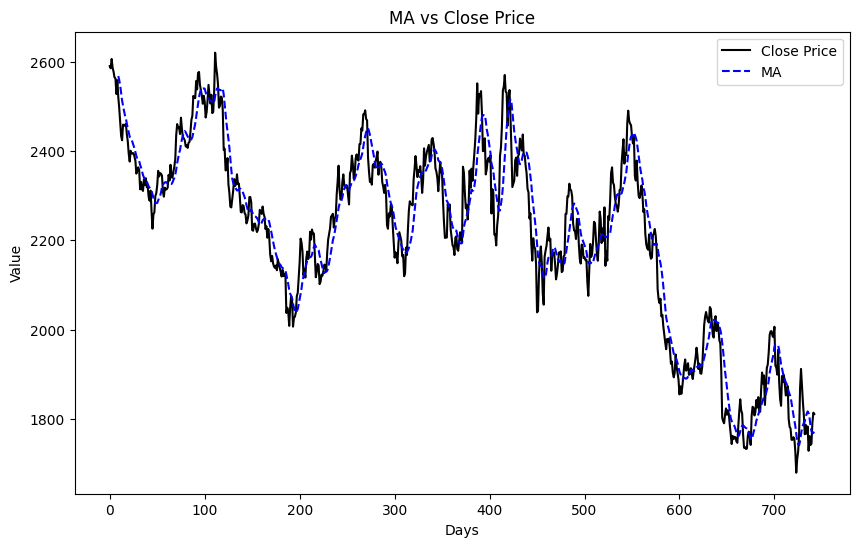

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Price'], label='Close Price', color='black')
plt.plot(df.index, df['MA'], label='MA', color='blue', linestyle='--')
plt.title('MA vs Close Price')
plt.xlabel('Days')
plt.ylabel('Value')
plt.legend()
plt.show()

# RSI

In [ ]:
def calculate_rsi(data, window_size):
    close_prices = data['Price']

    # Calculating daily price changes
    price_diff = close_prices.diff(1)

    # Calculating gain and loss
    gain = price_diff.where(price_diff > 0, 0)
    loss = -price_diff.where(price_diff < 0, 0)

    # Calculating average gain and average loss over the specified window
    avg_gain = gain.rolling(window=window_size, min_periods=1).mean()
    avg_loss = loss.rolling(window=window_size, min_periods=1).mean()

    # Calculating the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculating the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Choosing desired window size
window_size = 14

# Calculating the RSI and add it to the DataFrame
df['RSI'] = calculate_rsi(df, window_size)


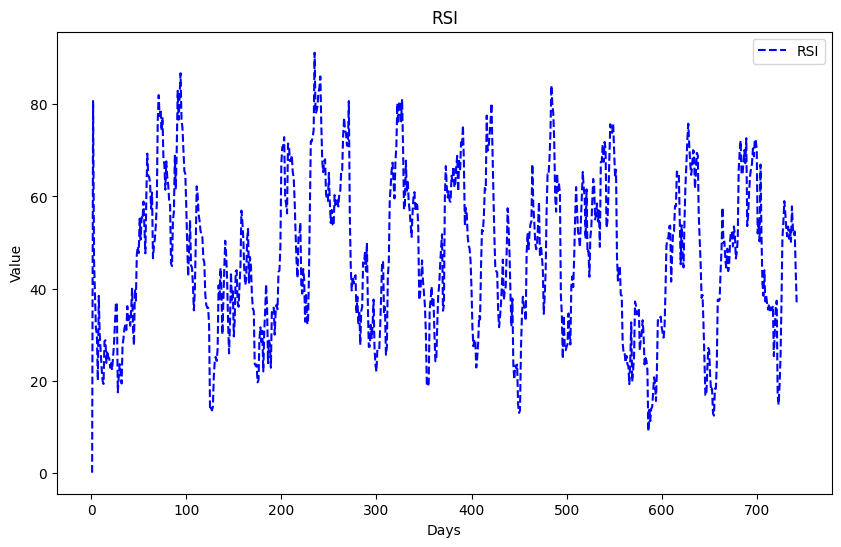

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['RSI'], label='RSI', color='blue', linestyle='--')
plt.title('RSI')
plt.ylabel('Value')
plt.xlabel('Days')

plt.legend()
plt.show()

# Bollinger Bands

In [ ]:
df['Upper'], df['Middle'], df['Lower'] = (
    df["Price"].rolling(window=20).mean() + 2 * df["Price"].rolling(window=20).std(),
    df["Price"].rolling(window=20).mean(),
    df["Price"].rolling(window=20).mean() - 2 * df["Price"].rolling(window=20).std()
)

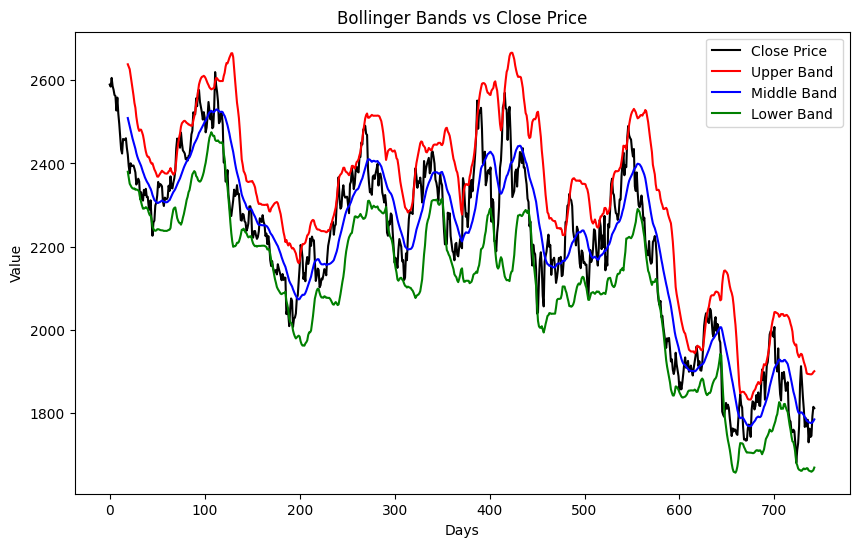

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Price'], label='Close Price', color='black')
plt.plot(df.index, df['Upper'], label='Upper Band', color='Red')
plt.plot(df.index, df['Middle'], label='Middle Band', color='blue')
plt.plot(df.index, df['Lower'], label='Lower Band', color='Green')

plt.title('Bollinger Bands vs Close Price')
plt.xlabel('Days')
plt.ylabel('Value')
plt.legend()
plt.show()

# MACD (Moving Average Convergence Divergence)

In [ ]:
df['MACD'] = df["Price"].ewm(span=12).mean() - df["Price"].ewm(span=26).mean()

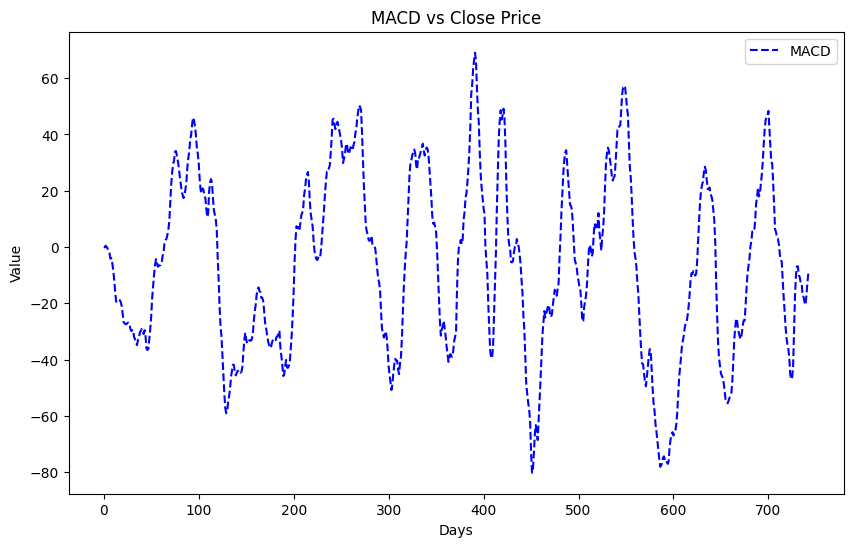

In [ ]:
plt.figure(figsize=(10, 6))
#plt.plot(df.index, df['Price'], label='Close Price', color='black')
plt.plot(df.index, df['MACD'], label='MACD', color='blue', linestyle='--')
plt.title('MACD vs Close Price')
plt.xlabel('Days')
plt.ylabel('Value')
plt.legend()
plt.show()

# Correlation Analysis

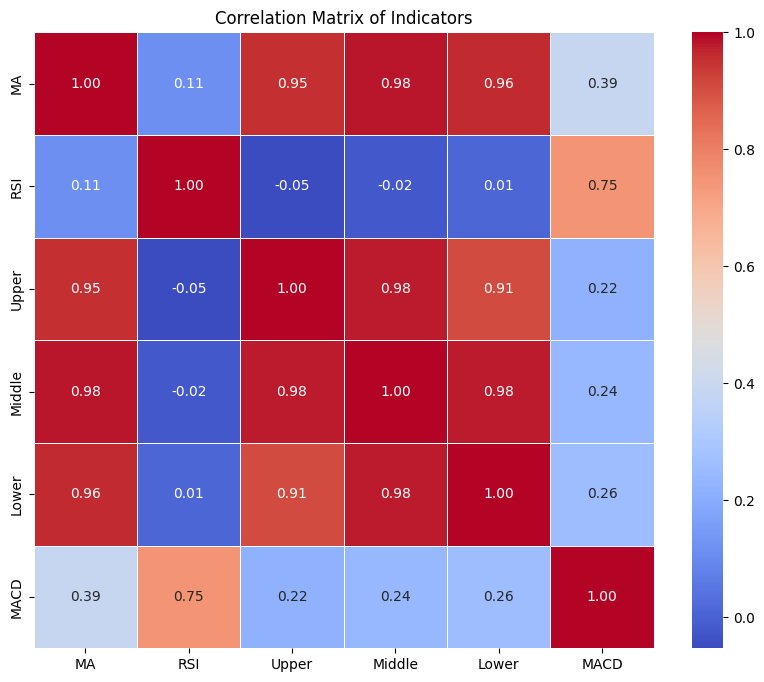

In [ ]:
import seaborn as sns
correlation_matrix = df[['MA', 'RSI', 'Upper', 'Middle', 'Lower', 'MACD']].corr()
#Combined Indicator (Weighted Average)
combined_weights = np.array(correlation_matrix['MA'].abs())
# Normalizing weights
combined_weights /= combined_weights.sum()

df['Combined'] = np.average(df[['MA', 'RSI', 'Upper', 'Middle', 'Lower', 'MACD']], axis=1, weights=combined_weights)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Indicators')
plt.show()

In [ ]:
#print(combined_weights)

# Prediction on position for each day

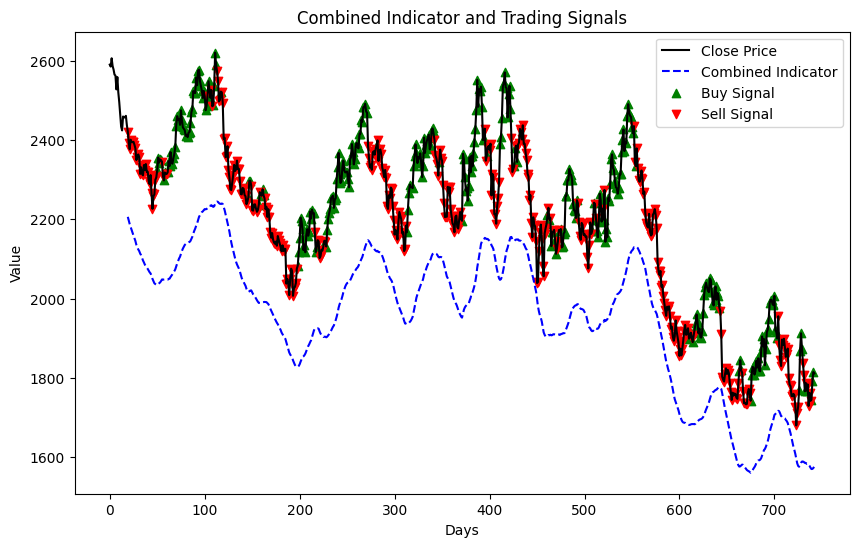

In [ ]:
# Generating trading signals
df['Signal'] = np.where(df['Combined'].shift(-1) < df['Combined'], 1, np.where(df['Combined'].shift(-1) > df['Combined'], -1, 0))
# Visualizing the signal
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Price'], label='Close Price', color='black')
plt.plot(df.index, df['Combined'], label='Combined Indicator', color='blue', linestyle='--')
plt.scatter(df[df['Signal'] == -1].index, df[df['Signal'] == -1]['Price'], marker='^', color='green', label='Buy Signal')
plt.scatter(df[df['Signal'] == 1].index, df[df['Signal'] == 1]['Price'], marker='v', color='red', label='Sell Signal')
plt.title('Combined Indicator and Trading Signals')
plt.xlabel('Days')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
df['Actual_Movement'] = np.where(df['Price'].shift(-1) < df['Price'], 1, np.where(df['Price'].shift(-1) > df['Price'], -1, 0))
correct_predictions = np.sum(df['Signal'] == df['Actual_Movement'])
total_predictions = len(df) - 1  # Excluding the last row where we don't have the next day's price movement information
df = df.iloc[30:,:] #Since our indicators does not predict starting value due to window size , dropping starting values
accuracy = correct_predictions / total_predictions
print(f'Accuracy of Predictions: {accuracy * 100:.2f}%')

Accuracy of Predictions: 57.68%


In [ ]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %,MA,RSI,Upper,Middle,Lower,MACD,Combined,Signal,Actual_Movement
30,11/16/2023,2363.35,"2,349.95",2373.70,2346.80,435.61K,0.27%,2379.565,23.592043,2484.770993,2410.1525,2335.534007,-29.543577,2123.944329,1,1
31,11/15/2023,2356.90,"2,335.50",2362.35,2326.80,104.54K,1.84%,2377.615,21.452145,2478.401595,2404.7725,2331.143405,-29.431176,2119.918705,1,1
32,11/13/2023,2314.30,"2,325.00",2325.00,2311.65,127.88K,-0.71%,2368.995,19.378882,2481.416603,2398.8175,2316.218397,-32.157909,2113.726148,1,-1
33,11/12/2023,2330.90,"2,329.70",2332.55,2324.10,35.99K,0.72%,2362.630,27.620467,2481.168491,2394.1650,2307.161509,-32.682690,2109.377638,1,1
34,11/10/2023,2314.30,"2,308.00",2317.00,2298.15,499.80K,0.16%,2354.630,29.209351,2475.276524,2386.9275,2298.578476,-33.958832,2102.723858,1,1


In [ ]:
df.to_csv('/content/drive/My Drive/reliance_prediction.csv', index=False)
